In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# import sys
# sys.path.append("/home/conda/RAID_5_14TB/3d_lidar_detection_evaluation/")

import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from dataset.KITTI_dataset import KittiDataset,KITTI_collate_fn_Wcalib
from models.pillar_models import NET_4D_EffDet
from tqdm import tqdm


import matplotlib.pyplot as plt
from  matplotlib.transforms import Affine2D 
from matplotlib.lines import Line2D
import pandas as pd
from mmcv.ops.iou3d import nms3d,nms3d_normal

xyz_range = np.array([0,-40.32,-2,80.64,40.32,3])
xy_voxel_size= np.array([0.16,0.16])
points_per_pillar = 32
n_pillars=12000


dataset = KittiDataset(xyz_range = xyz_range,xy_voxel_size= xy_voxel_size,points_per_pillar = points_per_pillar,n_pillars=n_pillars,return_calib=True,test=True)
dataloader_vis = DataLoader(dataset, batch_size=1,collate_fn= KITTI_collate_fn_Wcalib, num_workers=1, shuffle=True)

anchor_dict = np.load("./anchors/cluster_kitti_3scales_3anchor.npy",allow_pickle=True).item()
model_dict = torch.load("./weights/model_KITTI_exp.pth")
model = NET_4D_EffDet(anchor_dict,n_classes=4,rgb_deform=False,\
                      n_pnt_pillar=points_per_pillar,\
                      xyz_range=xyz_range,\
                      xy_voxel_size=xy_voxel_size)
model.load_state_dict(model_dict["params"],strict=False)
model.cuda()
model.eval()
''

ModuleNotFoundError: No module named 'dataset'

In [10]:
np.random.seed(42)
pred_dfs = pd.DataFrame(columns=["class","x","y","z","l","w","h","r","score"])
gt_dfs = pd.DataFrame(columns=["class","x","y","z","l","w","h","r","score"])
    
    
    
int2clss = {0:"car",1:"pedestrian",2:"cyclist",3:"misc"}
for idx,(img,(pillars, coord, contains_pillars),(pillar_img_pts,rgb_coors,contains_rgb),targets,calibs) in tqdm(enumerate(dataloader_vis)):

    target = targets[0]
    gt_boxes= target["boxes"].view(-1,7)
    gt_labels= target["labels"].view(-1,1)
    gt_labels = [int2clss[x] for x in gt_labels.numpy().flatten()]
    gt_df = pd.DataFrame(gt_boxes.numpy(),columns=["x","y","z","l","w","h","r"])
    
    gt_df["class"] = gt_labels
    gt_df["score"] = np.ones(gt_df.shape[0])
    
    gt_df = gt_df[["class","x","y","z","l","w","h","r","score"]]
    gt_df.to_csv(f"./prediction_eval/gt/{idx:06d}.csv",sep=",",index=False,header=False)
    
    with torch.no_grad():
        outputs,pseudo_img,dynamic_img = model(img.cuda(),pillars.float().cuda(), coord.cuda(), contains_pillars.cuda(),pillar_img_pts.float().cuda(),rgb_coors.cuda(),contains_rgb.cuda())
        
    probas,_ = outputs['pred_logits'][0, :, 0:].sigmoid().max(-1)
    keep = (probas >= 0.1).squeeze()
    pred_boxes = outputs['pred_boxes'][0, keep].detach().cpu()
    pred_clss = outputs['pred_logits'][0, :, 0:].sigmoid()[keep].argmax(-1).cpu().numpy()
    pred_score = probas[keep.type(torch.bool)].float()
    
    if len(pred_boxes)>0:
        pred_idx =nms3d_normal(pred_boxes.cuda(),pred_score,0.1)
        pred_boxes = pred_boxes[pred_idx]
        pred_score = pred_score[pred_idx]
        pred_clss = [int2clss[x] for x in pred_clss[pred_idx.cpu().numpy()]]
    
    pred_df = pd.DataFrame(pred_boxes.numpy(),columns=["x","y","z","l","w","h","r"])
    
    
    pred_df["class"] = pred_clss
    pred_df["score"] = pred_score.cpu().numpy()

    
    pred_df = pred_df[["class","x","y","z","l","w","h","r","score"]]
    
    pred_df.to_csv(f"./prediction_eval/pred/{idx:06d}.csv",sep=",",index=False,header=False)
    
    # pred_dfs = pred_dfs.append(pred_df)
    # gt_dfs = gt_dfs.append(gt_df)
    # break
    
    

481it [01:58,  4.06it/s]


In [11]:
# pred_boxes.cuda(),pred_score

Starting evaluation for 481 file predictions
--------------------------------------------
Confirmation prediction ground truth file pairs.
Evaluation examples

Done!
----------------------------------
Calculating metrics for car class
----------------------------------
Number of ground truth labels:  2087
Number of detections:   3520
Number of true positives:   1913
Number of false positives:   1607
(3520, 2)
Mean AP: 0.838 
F1 Score: 0.844 
 
Average 2D Translation Error [m]:  0.2438 
Average 3D Translation Error [m]:  0.2696 
Average Scale Error:  0.0906 
Average Orientation Error [rad]:  0.1908 
 
Calculating metrics for pedestrian class
----------------------------------
Number of ground truth labels:  366
Number of detections:   1056
Number of true positives:   328
Number of false positives:   728
(1056, 2)
Mean AP: 0.702 
F1 Score: 0.693 
 
Average 2D Translation Error [m]:  0.2282 
Average 3D Translation Error [m]:  0.2499 
Average Scale Error:  0.1773 
Average Orientation Error

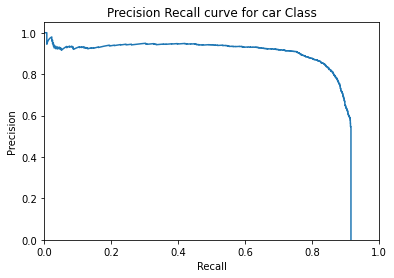

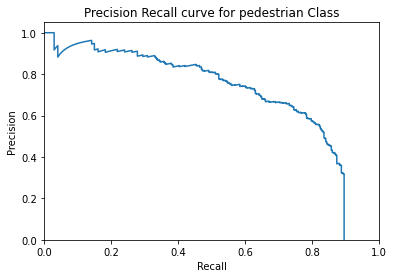

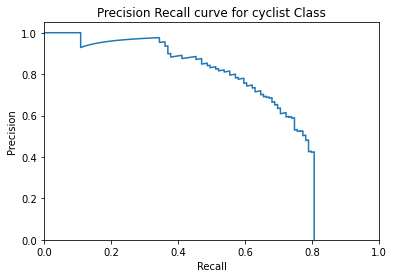

In [12]:
# !python ./3d_lidar_detection_evaluation/nuscenes_eval.py --pred_labels ./prediction_eval/prediction.txt --gt_labels ./prediction_eval/groundtruth.txt --format "class x y z l w h r score"
from evaluation_code.nuscenes_eval_core import NuScenesEval
NuScenesEval("./prediction_eval/pred", "./prediction_eval/gt", "class x y z l w h r score",save_loc="./")